# Replication of Clayson et al., 2023 Preprocessing scripts

In [172]:
import numpy as np
import mne
from sklearn.neighbors import NearestNeighbors
import re
from collections import OrderedDict
import matplotlib.pyplot as plt
import pandas as pd
import json
import os

Constants

In [169]:
random_state = 42
# GNG | SST | Flanker
paradigm = 'GNG'
case = 'RE'

GNG INFO: 
- B-GNG-069 - additional trigger (9) on the position 359804;
- B-GNG-102 - additional trigger (15) on the position 328219;

- B-GNG-005 - signal should be re-reffered only to the A1 (A2 is very noisy);

Exclude:
- B-GNG-086:
    - 117 GO trials without reaction; 
    - no trials with good feedback (fast responses); 
    - 13 uninhibited NoGo trials;
        
- B-GNG-075: no EEG recording;


Paths

In [170]:
trigger_dir_path = f'data/{paradigm}/raw/triggers/'
bdf_dir_path = f'data/{paradigm}/raw/bdfs/'
behavioral_dir_path = f'data/{paradigm}/behavioral/'
preprocessed_data_dir_path = f'data/{paradigm}/preprocessed/{case}/'

Utils

In [197]:
def read_trigger_map(file_name):
    line_count = 0
    trigger_map = []
    with open(file_name, 'r') as file:
        # Read each line and increment the counter
        line = file.readline()
        try:
            match = re.search("(.*):(.*)(\\n)", line)
            trigger = (match.group(1), match.group(2), )
            trigger_map.append(trigger)
        except:
            pass
        while line:
            line_count += 1
            line = file.readline()
            try:
                match = re.search("(.*):(.*)(\\n)", line)
                trigger = (match.group(1), match.group(2), )
                trigger_map.append(trigger)
            except:
                pass

    assert len(trigger_map) == line_count

    return trigger_map

def create_triggers_dict(trigger_map):
    triggers_codes = [item[1] for item in trigger_map]
    # Create an ordered dictionary to maintain order and remove duplicates
    unique_ordered_dict = OrderedDict.fromkeys(triggers_codes)
    numbered_dict = {key: 1000 + number for number, key in enumerate(unique_ordered_dict.keys())}
    reversed_numbered_dict = {1000 + number: key for number, key in enumerate(unique_ordered_dict.keys())}
    return numbered_dict, reversed_numbered_dict

def replace_trigger_names(raw, trigger_map, new_response_event_dict=None, replace=False, search='RE'):
    # Replace event IDs in the Raw object
    events = mne.find_events(raw, stim_channel='Status')
    new_events_list = events.copy()
    print(f'EVENTS: {new_events_list}')

    assert len(events) == len(trigger_map)

    trigger_map_codes, mapping = create_triggers_dict(trigger_map)

    for idx, event in enumerate(events):
        event_id = str(event[2])[-1]
        trigger_id = trigger_map[idx][0]
        trigger_new_code = trigger_map[idx][1]
        
        try:
            assert event_id == trigger_id
        except:
            print(f'An event {idx} has different number than in provided file. {trigger_id} expected, {str(event[2])} found. Triggers may need to be checked.')

        trigger_new_code_int = trigger_map_codes[trigger_new_code]
        new_events_list[idx][2] = trigger_new_code_int

    annot_from_events = mne.annotations_from_events(
        events=new_events_list,
        event_desc=mapping,
        sfreq=raw.info["sfreq"],
        orig_time=raw.info["meas_date"],
    )
    raw_copy = raw.copy()
    raw_copy.set_annotations(annot_from_events)

    return raw_copy

def find_items_matching_regex(dictionary, regex):
    pattern = re.compile(regex)
    matching_items = {key: value for key, value in dictionary.items() if pattern.match(key)}
    return matching_items

def create_events_mappings(trigger_map, case='RE'):
    trigger_map_codes, mapping = create_triggers_dict(trigger_map)

    event_dict = {}
    events_mapping = {}
    new_response_event_dict = {"correct_response": 0, "error_response": 1}

    if case == 'RE':
        events_mapping = {
            'correct_response': [],
            'error_response': [],
        }
        # find response events from experimental blocks
        regex_pattern = r'RE\*ex\*.*\*num_separator'
        event_dict = find_items_matching_regex(trigger_map_codes, regex_pattern)
    
        for event_id in event_dict.keys():
            event_id_splitted = event_id.split('*')
    
            if (event_id_splitted[2][0] == event_id_splitted[3][0]) and (
                    event_id_splitted[3][-1] == '1'):
                events_mapping['correct_response'].append(event_dict[event_id])
            else:
                events_mapping['error_response'].append(event_dict[event_id])
        
    else:
        print('Not implemented for feedback and stimuli')
        
    return event_dict, events_mapping, new_response_event_dict

def create_epochs(
        raw,
        tmin=-.1,
        tmax=.6,
        events_to_select=None,  # event_dict
        new_events_dict=None,  # new_event_dict
        events_mapping=None,  # events_mapping
        reject=None,
        reject_by_annotation=False,
):
    # select specific events
    events, event_ids = mne.events_from_annotations(raw, event_id=events_to_select)

    # Merge different events of one kind
    for mapping in events_mapping:
        events = mne.merge_events(
            events=events,
            ids=events_mapping[mapping],
            new_id=new_events_dict[mapping],
            replace_events=True,
        )

    # Read epochs
    epochs = mne.Epochs(
        raw=raw,
        events=events,
        event_id=new_events_dict,
        tmin=tmin,
        tmax=tmax,
        baseline=None,
        reject_by_annotation=reject_by_annotation,
        preload=True,
        reject=reject,
        picks=['eeg', 'eog'],
    )
    
    return epochs


def ocular_correction_ica(raw, raw_unfiltered, veog=[], heog=[], info=False, from_template='auto'):
    # filtered_raw = raw.copy().filter(l_freq=1.0, h_freq=None)
    # 
    # # peak-to-peak amplitude rejection parameters to exclude very noisy epochs
    # epochs_ica = create_epochs(
    #     filtered_raw,
    #     tmin=-.4,
    #     tmax=.8,
    #     reject=dict(eeg=100e-5),
    # )
    # 
    # ica = mne.preprocessing.ICA(
    #     n_components=36,
    #     method='infomax',
    #     max_iter="auto",
    #     random_state=random_state
    # )
    # ica.fit(epochs_ica)
    # 
    # ica.exclude = []
    # # find which ICs match the VEOG pattern
    # eog_epochs = mne.preprocessing.create_eog_epochs(
    #     filtered_raw,
    #     tmin=-0.5, tmax=0.5
    # )
    # 
    # eog_epochs.plot_image(combine="mean")
    # eog_epochs.average().plot_joint()
    # 
    # veog_indices, veog_scores = ica.find_bads_eog(
    #     eog_epochs,
    #     ch_name=veog,
    #     threshold=0.9,
    #     measure='correlation'
    # )
    # heog_indices, heog_scores = ica.find_bads_eog(
    #     eog_epochs,
    #     ch_name=heog,
    #     threshold=0.8,
    #     measure='correlation'
    # )
    # 
    # print(f'Excluded ICA components: {veog_indices + heog_indices}')
    # 
    # ica.plot_components(veog_indices + heog_indices)
    # 
    # ica.exclude = veog_indices + heog_indices
    # 
    # reconstructed_epochs = epochs.copy()
    # ica.apply(reconstructed_epochs)

    filtered_raw_ica = raw_unfiltered.copy().drop_channels(['EXG7', 'EXG8']).filter(l_freq=1.0, h_freq=None)

    ica = mne.preprocessing.ICA(
        n_components=12,
        method='infomax',
        max_iter="auto",
        random_state=random_state
    )
    ica.fit(filtered_raw_ica)
    
    ica.exclude = []
    
    # find which ICs match the VEOG pattern
    veog_indices, veog_scores = ica.find_bads_eog(
        filtered_raw_ica,
        ch_name=veog,
        threshold=0.9,
        measure='correlation'
    )

    # find which ICs match the HEOG pattern
    heog_indices, heog_scores = ica.find_bads_eog(
        filtered_raw_ica,
        ch_name=heog,
        threshold=0.7,
        measure='correlation'
    )   
    
    if info:
        print('ICA components')
        fig = ica.plot_components()
        print(f"VEOG indices: {veog_indices}\nVEOG scores: {veog_scores}\n")
        print(f"HEOG indices: {heog_indices}\nHEOG scores: {heog_scores}\n")
  
    if (len(veog_indices + heog_indices) == 0 and from_template == 'auto') or from_template == True:
        print('Using templates...')
        templates_ica = pd.read_pickle('data/eog_templates.pkl')

        template_veog_component = templates_ica['VEOG'].to_numpy()[0].flatten()
        template_heog_component = templates_ica['HEOG'].to_numpy()[0].flatten()

        mne.preprocessing.corrmap(
            [ica], 
            template=template_veog_component, 
            threshold=0.9, 
            label="veog blink", 
            plot=False
        )
        mne.preprocessing.corrmap(
            [ica], 
            template=template_heog_component, 
            threshold=0.8, 
            label="heog blink", 
            plot=False
        )

        veog_indices = ica.labels_['veog blink']
        heog_indices = ica.labels_['heog blink']

    print(f'Excluded ICA components:\nVEOG: {veog_indices}\nHEOG: {heog_indices}')
    fig = ica.plot_components(veog_indices + heog_indices)
    
    ica.exclude = veog_indices + heog_indices
    
    reconstructed_raw = raw.copy()
    ica.apply(reconstructed_raw)
    
    del filtered_raw_ica

    return reconstructed_raw


def get_k_nearest_neighbors(target_ch_name, epochs, k=6):
    """
    Finds k nearest neighbors of given channel according to the 3D channels positions from the Epoch INFO
    :param target_ch_name: String
        Name of the target channel.
    :param epochs: mne Epochs
        Epochs with info attribute that consists of channels positions.
    :param k: int
        Number of neighbors to use by default for kneighbors queries. 
    :return: 
        indices: ndarray of shape (n_neighbors)
            Indices of the nearest channels.
        neighbor_ch_names: ndarray of shape (n_neighbors)
            Names of the nearest channels.   
    """
    epochs_copy_eeg_channels = epochs.copy().pick('eeg')
    info = epochs_copy_eeg_channels.info
    ch_names = epochs_copy_eeg_channels.info['ch_names']
    
    chs = [info["chs"][pick] for pick in np.arange(0,len(ch_names))]
    electrode_positions_3d =[]
    
    for ch in chs:
        electrode_positions_3d.append((ch['ch_name'], ch["loc"][:3]))
    
    neighbors_model = NearestNeighbors(n_neighbors=k+1, algorithm='auto')
    ch_coordinates = np.array([ch_name_coordinates[1] for ch_name_coordinates in electrode_positions_3d])

    neighbors_model.fit(ch_coordinates)

    target_ch_coordinates = np.array([ch_name_coordinates[1] for ch_name_coordinates in electrode_positions_3d if ch_name_coordinates[0] == target_ch_name])
    
    target_ch_coordinates = target_ch_coordinates.reshape(1,-1)

    distances, indices = neighbors_model.kneighbors(target_ch_coordinates)
    neighbor_ch_names = []
    
    # Print the nearest neighbors without the first (self) neighbor
    # print(f"{k} Nearest Neighbors of {target_ch_name}:")
    for i, (distance, index) in enumerate(zip(distances.flatten(), indices.flatten())):
        if i == 0:
            pass
        else:
            neighbor_point = electrode_positions_3d[index]
            # print(f"Neighbor {i + 1}: Index {index}, Distance {distance:.2f}, Coordinates {neighbor_point}")
            neighbor_ch_names.append(neighbor_point[0])
            
    return indices.flatten()[1:], np.array(neighbor_ch_names)


def find_bad_trails(epochs):
    """
    Channels that meet following conditions will be marked as bad for the trail:
        (1) Channels with a voltage difference of 100 μV through the duration of the epoch;
        (2) Channels that were flat;
        (3) Channels with more than a 30 μV difference with the nearest six neighbors; 
    :param mne Epochs 
        Epochs to find bad channels per trial. 
    :return: drop_log: tuple of n_trials length
        Tuple representing bad channels names per trial.
    """
    epochs_copy = epochs.copy()
    
    # channels with a voltage difference of 100 μV through the duration of the epoch
    reject_criteria = dict(eeg=100e-6)
    # flat channels (less than 1 µV of peak-to-peak difference)
    flat_criteria = dict(eeg=1e-6)
    
    epochs_copy.drop_bad(reject=reject_criteria, flat=flat_criteria)
    drop_log = epochs_copy.drop_log

    # channels with more than a 30 μV difference with the nearest six neighbors
    for idx, _ in enumerate(epochs_copy):
        epoch = epochs[idx]
        epoch_data = epoch.get_data(copy=True)
        for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
            mean_channel_data = np.array(np.mean(epoch_data[0,ch_idx,:]))
    
            ch_neighbors_indices, ch_neighbors_names = get_k_nearest_neighbors(
                target_ch_name = ch_name,
                epochs = epoch,
                k=6
            )
    
            mean_neighbors_data = np.array([np.mean(epoch_data[0, ch_neighbor_index, :]) 
                                            for ch_neighbor_index in ch_neighbors_indices])
    
            # # if channels has more than a 30 μV difference with the nearest six neighbors
            if (abs(mean_neighbors_data - mean_channel_data) > 30e-6).all():
                print(f'BAD------ trail index {idx}, channel: {ch_name}')
                print(mean_channel_data)
                print(mean_neighbors_data)
    
                new_drop_log_item = drop_log[idx] + (ch_name, ) if ch_name not in drop_log[idx] else drop_log[idx]
                drop_log = tuple(new_drop_log_item if i == idx else item for i, item in enumerate(drop_log))

    del epochs_copy
    
    return drop_log

def calculate_percentage(tuple_of_tuples, element):
    total_tuples = len(tuple_of_tuples)
    # Avoid division by zero
    if total_tuples == 0:
        return 0 

    tuples_with_element = sum(1 for inner_tuple in tuple_of_tuples if element in inner_tuple)
    percentage = (tuples_with_element / total_tuples)
    return percentage

def find_global_bad_channels(epochs, drop_log):
    '''
    (1) Channels with an absolute correlation with the nearest six neighboring channels that fell below .4;
    (2) Channels that were marked as bad for more than 20% of epochs;
    :param epochs: 
    :param drop_log: 
    :return: 
    '''
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True)
    concatenated_epochs_data = np.concatenate(epochs_data, axis=1)
    
    global_bad_channels_drop_log = {}
    
    # (1) Channels with an absolute correlation with the nearest six neighboring channels that fell below .4
    for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
        channel_data = concatenated_epochs_data[ch_idx]
    
        ch_neighbors_indices, ch_neighbors_names = get_k_nearest_neighbors(
            target_ch_name = ch_name,
            epochs = epochs_copy,
            k=6
        )
        channel_neighbors_data = np.array([concatenated_epochs_data[ch_neighbor_index]
                                           for ch_neighbor_index in ch_neighbors_indices])
        channels_corr = np.tril(np.corrcoef(channel_neighbors_data, channel_data), k=-1)
    
        if (abs(channels_corr[-1][:-1]) < .4).all():
            print(f'BAD------ global channel: {ch_name}, low corr')
            print(channels_corr[-1][:-1])
    
            # mark channel as globally bad
            global_bad_channels_drop_log[ch_name] = ['LOW CORR NEIGH']
            # update drop_log
            drop_log = tuple(drop_log[i] + (ch_name,)
                             if ch_name not in drop_log[i] else drop_log[i] for i, item in enumerate(drop_log))
    
    # (2) Channels that were marked as bad for more than 20% of epochs   
    for ch_name, ch_idx in zip(epochs_copy.info['ch_names'], np.arange(0, len(epochs_copy.info['ch_names']))):
        percentage = calculate_percentage(drop_log, ch_name)
    
        if percentage > 0.2:
            print(f'BAD------ global channel: {ch_name}, percentage: {percentage}')
    
            if ch_name in global_bad_channels_drop_log:
                global_bad_channels_drop_log[ch_name].append('BAD FOR MORE THAN 20%')
            else:
                global_bad_channels_drop_log[ch_name] = ['BAD FOR MORE THAN 20%']
    
            # update drop_log
            drop_log = tuple(drop_log[i] + (ch_name,)
                             if ch_name not in drop_log[i] else drop_log[i] for i, item in enumerate(drop_log))
            
    del epochs_copy
            
    return drop_log, global_bad_channels_drop_log

def mark_bad_trials(epochs, drop_log, threshold=0.1):
    """
    If more than 10% of channels were marked bad for an epoch (trial), the entire epoch was rejected
    :param drop_log: 
    :return: trials_to_drop: ndarray
    '"""
    trials_to_drop_indices = []
    epochs_copy = epochs.copy()

    if len(epochs_copy) == len(drop_log):
        threshold_items = int(threshold * len(epochs_copy.info['ch_names']))
        for idx, item in enumerate(drop_log):
            if len(item) > threshold_items:
                print(f'BAD TRAIL (exceeded threshold for bad channels): {idx}')
                trials_to_drop_indices.append(idx)
        
        # update drop_log
        for trial_idx in trials_to_drop_indices:
            drop_log = tuple(drop_log[i] + ('TO DROP',) if i == trial_idx else item for i, item in enumerate(drop_log))

    else:
        print(f'Epochs length is not equal drop_log length:\nepochs: {len(epochs)}\ndrop_log: {len(drop_log)}')
    
    return trials_to_drop_indices, drop_log

def reject_bad_trials(epochs, drop_log, trials_to_drop_indices=None):
    clean_epochs = epochs.copy()
    
    clean_epochs = clean_epochs.drop(
        indices = trials_to_drop_indices,
        reason = 'MORE THAN 10% CHANNELS MARKED AS BAD',
    )
    
    # update drop_log
    for trial_idx in trials_to_drop_indices:
        drop_log = tuple(('REJECTED',) if i == trial_idx else element for i, element in enumerate(drop_log))
    
    return clean_epochs, drop_log

def interpolate_bad_channels(epochs, drop_log, global_bad_channels_drop_log):
    """
    Bad channels were interpolated using spherical splines
    :param epochs: 
    :param drop_log: 
    :param global_bad_channels_drop_log: 
    :return: 
    """

    epochs_copy = epochs.copy()
    epochs_copy.info['bads'] = list(global_bad_channels_drop_log.keys())
    epochs_interpolated_bad_channels = epochs_copy.interpolate_bads(method='spline')

    # update drop log to remove interpolated channels
    updated_drop_log = drop_log
    for ch_name in list(global_bad_channels_drop_log.keys()):
        updated_drop_log = tuple(tuple(element for element in drop_log_item if element != ch_name) for drop_log_item in updated_drop_log)
    
    return epochs_interpolated_bad_channels, updated_drop_log

def create_erps_waves(epochs, drop_log, type = 'error_response', tmin=0, tmax=0.1, picks=['FCz']):
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True, picks=picks, tmin=tmin, tmax=tmax)
    events = epochs_copy.events

    eeg_data = []

    if (len(epochs_data) == len(drop_log)) & (len(events) == len(drop_log)):
        for idx, item in enumerate(drop_log):
            if events[idx][-1] == new_response_event_dict[type]:
                if ('TO DROP' in item) or any(element in item for element in picks):
                    pass
                else:
                    eeg_data.append(epochs_data[idx])
            else:
                pass
        return np.array(eeg_data)
    else:
        print(f'Epochs length is not equal to drop_log length:\nepochs: {len(epochs_data)}\ndrop_log: {len(drop_log)}')
        return None

def create_erps(epochs, drop_log, type = 'error_response', tmin=0, tmax=0.1, picks=['FCz']):
    epochs_copy = epochs.copy()
    epochs_data = epochs_copy.get_data(copy=True, picks=picks, tmin=tmin, tmax=tmax)
    events = epochs_copy.events

    erps_data = []

    if (len(epochs_data) == len(drop_log)) & (len(events) == len(drop_log)):
        for idx, item in enumerate(drop_log):
            if events[idx][-1] == new_response_event_dict[type]:
                if ('TO DROP' in item) or any(element in item for element in picks):
                    erps_data.append([None])
                else:
                    erps_data.append(np.mean(epochs_data[idx], axis=-1))
            else:
                pass
        return np.array(erps_data)
    else:
        print(f'Epochs length is not equal to drop_log length:\nepochs: {len(epochs_data)}\ndrop_log: {len(drop_log)}')
        return None

In [198]:
def pre_process_eeg(input_fname, trigger_fname=None, parameters=None):
    # 0. read bdf
    raw = mne.io.read_raw_bdf(
        input_fname,
        eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'],
        exclude=['EXG5', 'EXG6'],
        preload=True
    )

    try:
        raw = raw.set_montage('biosemi64')
    except ValueError as e:
        if '[\'EXG7\', \'EXG8\']' in e.args[0]:
            raw = raw.set_montage('biosemi64', on_missing='ignore')
            print('On missing')
        else:
            print('Lacks important channels!')
    
    # 1. replace trigger names
    trigger_map = read_trigger_map(trigger_fname)
    raw_new_triggers = replace_trigger_names(raw, trigger_map)

    # 2. re-reference: to mastoids
    raw_ref = raw_new_triggers.copy().set_eeg_reference(ref_channels=['EXG7', 'EXG8'])

    # 3. 4-th order Butterworth filters
    raw_filtered = raw_ref.copy().filter(
        l_freq=.1,
        h_freq=30.0,
        n_jobs=10,
        method='iir',
        iir_params=None,
    )

    # 4. Notch filter at 50 Hz
    raw_filtered = raw_filtered.notch_filter(
        freqs=np.arange(50, (raw_filtered.info['sfreq'] / 2), 50),
        n_jobs=10,
    )
    
    # 5. ocular correction with ICA
    raw_corrected_eogs = ocular_correction_ica(
        raw_filtered, 
        raw_ref, 
        heog=['EXG3', 'EXG4'], 
        veog=['EXG1', 'EXG2'], 
        from_template=True, 
        info=True,
    )

    # 6. segmentation -400 to 800 ms around the response
    raw_corrected_eogs_drop_ref = raw_corrected_eogs.copy().drop_channels(['EXG7', 'EXG8']).pick('eeg')

    epochs = create_epochs(
        raw_corrected_eogs_drop_ref,
        tmin=-.4,
        tmax=.8,
        events_to_select=response_event_dict,  # response_event_dict
        new_events_dict=new_response_event_dict,  # new_response_event_dict
        events_mapping=response_events_mapping,  # events_mapping
        reject=None,
        reject_by_annotation=False,
    )

    # 7. Trial-wise Bad Channels Identification
    drop_log = find_bad_trails(epochs)

    # 8. Global Bad Channel Identification - <.4 corr with 6 neigh. and channels marked as bad for more than 20% trials
    drop_log, global_bad_channels_drop_log = find_global_bad_channels(epochs, drop_log)

    # 9. calculate trails to remove
    trials_to_drop_indices, drop_log = mark_bad_trials(epochs, drop_log, threshold=0.1)

    # 10. Interpolate bad channels (and thus update drop log)
    interpolated_epochs, drop_log = interpolate_bad_channels(epochs, drop_log, global_bad_channels_drop_log)

    # 11. Remove participants that have less then 6 trials
    clean_epochs, _ = reject_bad_trials(interpolated_epochs.copy(), drop_log, trials_to_drop_indices)
    if len(clean_epochs) < 6:
        print(f"Participant ID: {id} has not enough clean trials")
        return []

    # 13. Baseline correction
    interpolated_epochs.apply_baseline(baseline=(-0.4, -0.2),)

    return interpolated_epochs, drop_log

In [ ]:
def save_epochs_with_drop_log_separately(epochs, drop_log, id):
    # save drop_log
    with open(f'{preprocessed_data_dir_path}drop_log_{id}.json', 'w') as fjson:
        json.dump(drop_log, fjson)

    # save Epoch object
    epochs.save(f'{preprocessed_data_dir_path}preprocessed_{id}-epo.fif', overwrite=True)

    return print('Epochs saved to fif. Drop log saved to json.')

In [ ]:
def save_epochs_with_drop_log(epochs, drop_log, id):
    item = pd.DataFrame({
        'epochs': [epochs],
        'drop_log': [drop_log],
    })
    
    item.to_pickle(f'{preprocessed_data_dir_path}preprocessed_{id}.pkl')
    
    return print('Epochs saved to pickle.')

In [ ]:
def read_behavioral_file(id):
    
    behavioral_data_df = pd.read_csv(f'{behavioral_dir_path}beh_{id}.csv')

    trial_numerator = 1
    trial_numbers = []
    for i in range(0, len(behavioral_data_df)):
        if behavioral_data_df.iloc[i]['block type'] != 'experiment':
            trial_numbers.append(0)
        else:
            trial_numbers.append(trial_numerator)
            trial_numerator+=1
    
    behavioral_data_df['trial number'] = trial_numbers
    return behavioral_data_df

In [ ]:
def save_epochs_with_behavioral_data_long(epochs, drop_log, id, case='RE'):
    
    # read behavioral file
    behavioral_data_df = read_behavioral_file(id)

    beh_data_uninhibited_nogo_responses_df = behavioral_data_df[
        (behavioral_data_df['block type'] == 'experiment') &
        (behavioral_data_df['trial type'] != 'go') &
        (behavioral_data_df['reaction'] == False)
        ]
    print(f'Number of uninhibited NOGO trials: {len(beh_data_uninhibited_nogo_responses_df)}')
    
    beh_data_inhibited_nogo_responses_df = behavioral_data_df[
        (behavioral_data_df['block type'] == 'experiment') &
        (behavioral_data_df['trial type'] != 'go') &
        (behavioral_data_df['reaction'] == True)
        ]
    print(f'Number of inhibited NOGO trials: {len(beh_data_inhibited_nogo_responses_df)}')
    
    beh_data_correct_go_responses_df = behavioral_data_df[
        (behavioral_data_df['block type'] == 'experiment') &
        (behavioral_data_df['trial type'] == 'go') &
        (behavioral_data_df['response'] == 'num_separator')
        ]
    print(f'Number correct GO trials: {len(beh_data_correct_go_responses_df)}')

    results_df = pd.DataFrame()
    epochs_df = pd.DataFrame()
    behavioral_df = pd.DataFrame()
    if case == 'RE':
        behavioral_df = pd.concat([beh_data_uninhibited_nogo_responses_df, beh_data_correct_go_responses_df]).sort_values(by='trial number')
        
        print(f'Len drop log: {len(drop_log)}')
        print(f'Len behavioral df: {len(behavioral_df)}')
        assert len(behavioral_df) == len(drop_log)
                
        for idx, _ in enumerate(epochs):
            epoch = epochs[idx]
            epoch_type = list(epoch.event_id.keys())
            assert len(epoch_type) == 1
            drop_log_item = drop_log[idx]
            
            this_df = pd.DataFrame({
                'epoch': [epoch],
                'event': epoch_type,
                'drop_log': [drop_log_item],
            })

            epochs_df = pd.concat([epochs_df, this_df], ignore_index=True)

        # epochs_df.reset_index(drop=True, inplace=True)
        indexes = behavioral_df.index
        # Set the indexes of epochs to match reactions
        epochs_df.set_index(indexes, inplace=True)
        results_df = pd.concat([behavioral_df, epochs_df], axis=1)
        
    else:
        print('Not implemented')

    assert len(results_df) == len(behavioral_df) == len(epochs_df)

    results_df.to_pickle(f'{preprocessed_data_dir_path}preprocessed-beh_{id}.pkl')
    print('Epochs and behavioral data in long format saved to pickle.')
    
    return results_df

## Preprocessing

Read participant IDs

In [180]:
id_list = [item.split('.')[0] for item in os.listdir(bdf_dir_path)]

In [ ]:
for id in id_list:
    bdf_fname = f'{bdf_dir_path}{id}.bdf'
    trigger_fname = f'{trigger_dir_path}triggerMap_{id}.txt'
    
    try:
        trigger_map = read_trigger_map(trigger_fname)
        response_event_dict, response_events_mapping, new_response_event_dict = create_events_mappings(trigger_map)
        
        print(response_event_dict)
        print(response_events_mapping)
        print(new_response_event_dict)
        
        epochs_preprocessed, drop_log = pre_process_eeg(
            input_fname=bdf_fname,
            trigger_fname=trigger_fname
        )
    
        _ = save_epochs_with_behavioral_data_long(
            epochs_preprocessed,
            drop_log,
            id,
            case='RE',
        )
    except Exception as e: 
        print(e)   

In [199]:
id = 'A-GNG-050'

{'RE*ex*1_n*1_c_1*num_separator': 1032, 'RE*ex*2_n*2_c_1*num_separator': 1037, 'RE*ex*1_n*2_c_1*num_separator': 1042, 'RE*ex*1_n*1_c_2*num_separator': 1047, 'RE*ex*2_n*1_c_1*num_separator': 1048, 'RE*ex*2_n*2_c_2*num_separator': 1049}
{'correct_response': [1032, 1037], 'error_response': [1042, 1047, 1048, 1049]}
{'correct_response': 0, 'error_response': 1}
Extracting EDF parameters from /Users/anuszka/Projects/ERPinability/data/GNG/raw/bdfs/A-GNG-050.bdf...
BDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 393471  =      0.000 ...  1536.996 secs...
On missing
Trigger channel Status has a non-zero initial value of {initial_value} (consider using initial_event=True to detect this event)
1345 events found on stim channel Status
Event IDs: [ 65281  65282  65283  65284  65285  65286  65287  65288 130818]
EVENTS: [[   227 130816 130818]
 [   705  65280  65283]
 [  1098  65280  65284]
 ...
 [391628  65280  65288]
 [391700  65280  65281]
 [391887 

[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up band-stop filter

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower transition bandwidth: 0.50 Hz
- Upper transition bandwidth: 0.50 Hz
- Filter length: 1691 samples (6.605 s)


[Parallel(n_jobs=10)]: Done  66 out of  66 | elapsed:    0.6s finished
[Parallel(n_jobs=10)]: Using backend LokyBackend with 10 concurrent workers.
[Parallel(n_jobs=10)]: Done   8 tasks      | elapsed:    0.1s


Filtering raw data in 1 contiguous segment
Setting up high-pass filter at 1 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal highpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Filter length: 845 samples (3.301 s)


[Parallel(n_jobs=10)]: Done  66 out of  66 | elapsed:    0.4s finished
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.1s


Fitting ICA to data using 64 channels (please be patient, this may take a while)
Selecting by number: 12 components
 
Fitting ICA took 17.1s.
Using EOG channels: EXG1, EXG2
... filtering ICA sources
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 0.75 Hz)
- Upper passband edge: 10.00 Hz
- Upper transition bandwidth: 0.50 Hz (-12 dB cutoff frequency: 10.25 Hz)
- Filter length: 2560 samples (10.000 s)
... filtering target
Setting up band-pass filter from 1 - 10 Hz

FIR filter parameters
---------------------
Designing a two-pass forward and reverse, zero-phase, non-causal bandpass filter:
- Windowed frequency-domain design (firwin2) method
- Hann window
- Lower passband edge: 1.00
- Lower transition bandwidth: 0.

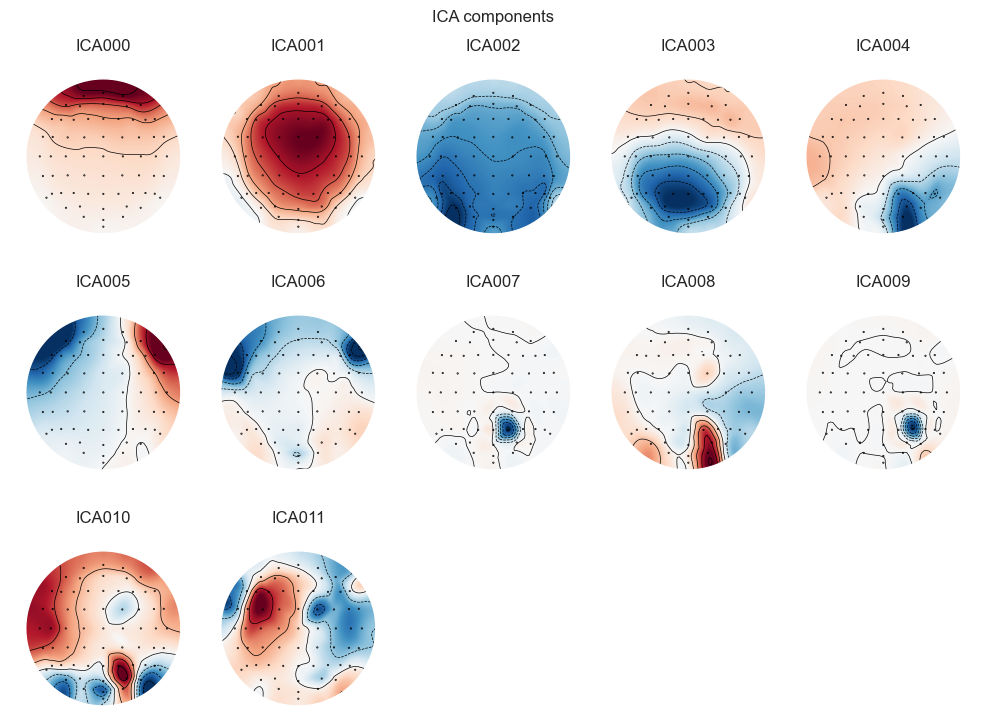

VEOG indices: [0]
VEOG scores: [array([ 0.97838105, -0.04508327,  0.08466915,  0.17007043,  0.05828284,
       -0.18813749, -0.04475993, -0.00345436,  0.00949823, -0.00314984,
        0.05067824, -0.01794751]), array([-0.90880875, -0.07753487,  0.1349142 ,  0.14574424,  0.044766  ,
        0.01170654, -0.11460828,  0.00959   ,  0.05284096,  0.01147061,
        0.04631705, -0.04576536])]

HEOG indices: []
HEOG scores: [array([ 0.24521658, -0.21228445,  0.3051077 ,  0.43530145,  0.15867486,
       -0.60375121, -0.23028842,  0.01438177,  0.0919837 ,  0.0155842 ,
        0.16215582, -0.10708341]), array([ 4.47920628e-01, -1.15764091e-01,  2.04610951e-01,  3.89899168e-01,
        7.47353164e-02,  6.33965256e-01, -1.42913200e-01, -2.02889698e-04,
        4.67346586e-03,  5.78447323e-03,  9.96017772e-02, -9.00365418e-02])]

Using templates...
Median correlation with constructed map: 1.000
At least 1 IC detected for each subject.
Median correlation with constructed map: 1.000
At least 1 IC det

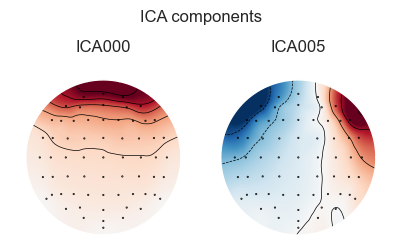

Applying ICA to Raw instance
    Transforming to ICA space (12 components)
    Zeroing out 2 ICA components
    Projecting back using 64 PCA components
Used Annotations descriptions: ['RE*ex*1_n*1_c_1*num_separator', 'RE*ex*1_n*1_c_2*num_separator', 'RE*ex*1_n*2_c_1*num_separator', 'RE*ex*2_n*1_c_1*num_separator', 'RE*ex*2_n*2_c_1*num_separator', 'RE*ex*2_n*2_c_2*num_separator']
Not setting metadata
251 matching events found
No baseline correction applied
0 projection items activated
Using data from preloaded Raw for 251 events and 308 original time points ...
0 bad epochs dropped
    Rejecting  epoch based on EEG : ['FT7']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['P4']
    Rejecting  epoch based on EEG : ['FC2']
    Rejecting  epoch based on EEG : ['P2']
    Rejecting  epoch based on EEG : ['FC3']
    Rejecting  epoch b

/var/folders/1_/b6g54cj10qj9pmtdn3v29ryc0000gn/T/ipykernel_6625/2310395529.py:483: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  epochs_interpolated_bad_channels = epochs_copy.interpolate_bads(method='spline')


In [200]:
bdf_fname = f'{bdf_dir_path}{id}.bdf' 
trigger_fname = f'{trigger_dir_path}triggerMap_{id}.txt'

trigger_map = read_trigger_map(trigger_fname)
response_event_dict, response_events_mapping, new_response_event_dict = create_events_mappings(trigger_map)

print(response_event_dict)
print(response_events_mapping)
print(new_response_event_dict)

epochs_preprocessed, drop_log = pre_process_eeg(
    input_fname=bdf_fname,
    trigger_fname=trigger_fname
)

In [ ]:
# save_epochs_with_drop_log(epochs_preprocessed, drop_log, id)

In [ ]:
# save_epochs_with_drop_log_separately(epochs_preprocessed, drop_log, id)

In [ ]:
# _ = save_epochs_with_behavioral_data_long(
#     epochs_preprocessed, 
#     drop_log, 
#     id,
#     case='RE',
# )

---
## Tests

In [163]:
id = 'A-GNG-000'

In [164]:
epochs_df = pd.read_pickle(f'{preprocessed_data_dir_path}preprocessed_{id}.pkl')
epochs = epochs_df['epochs'].to_numpy().flatten()[0]
drop_log = epochs_df['drop_log'].to_numpy().flatten()[0]

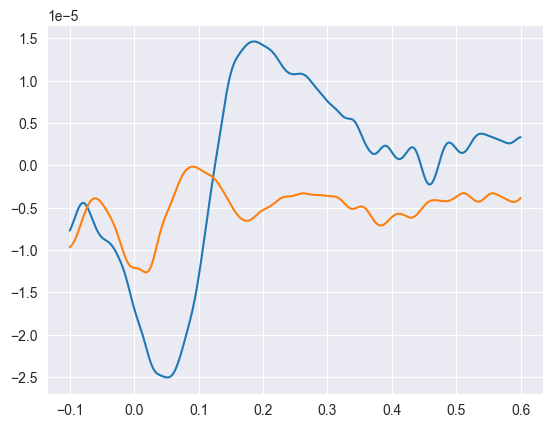

In [165]:
error_wave = create_erps_waves(epochs, drop_log, type='error_response', tmin=-0.1, tmax=0.6, picks=['FCz'])
correct_wave = create_erps_waves(epochs, drop_log, type='correct_response', tmin=-0.1, tmax=0.6, picks=['FCz'])

plt.plot(np.linspace(-0.1, 0.6, len(np.mean(error_wave, axis=0).flatten())), np.mean(error_wave, axis=0).flatten())
plt.plot(np.linspace(-0.1, 0.6, len(np.mean(correct_wave, axis=0).flatten())), np.mean(correct_wave, axis=0).flatten())

plt.show()

In [ ]:
error_wave.shape

In [ ]:
# ERPs scoring
ern_single_trials = create_erps(epochs_preprocessed, drop_log, type='error_response', tmin=0, tmax=0.1, picks=['FCz'])
pe_single_trials = create_erps(epochs_preprocessed, drop_log, type='error_response', tmin=0.2, tmax=0.4, picks=['Pz'])

---
## For testing

In [ ]:
input_fname = 'data/raw/A-GNG-000.bdf'
raw = mne.io.read_raw_bdf(
    input_fname, 
    eog=['EXG1', 'EXG2', 'EXG3', 'EXG4'], 
    exclude=['EXG5', 'EXG6'], 
    preload=True
)

try:
    raw = raw.set_montage('biosemi64')
except ValueError as e:
    if '[\'EXG7\', \'EXG8\']' in e.args[0]:
        raw = raw.set_montage('biosemi64', on_missing='ignore')
        print('On missing')
    else:
        print('Lacks important channels!')


file_path = 'data/raw/triggerMap_A-GNG-000.txt'
trigger_map = read_trigger_map(file_path)
raw_new_triggers = replace_trigger_names(raw, trigger_map)

In [ ]:
# 1. re-reference: to mastoids
raw_ref = raw_new_triggers.copy().set_eeg_reference(ref_channels=['EXG7', 'EXG8'])
# fig = raw_ref.plot(start=60, duration=1)

In [ ]:
# 2. 4-th order Butterworth filters
raw_filtered = raw_ref.copy().filter(
    l_freq=.1,
    h_freq=30.0,
    n_jobs=10,
    method='iir',
    iir_params=None,
)

In [ ]:
# 3. Notch filter at 50 Hz
raw_filtered = raw_filtered.notch_filter(
    freqs=np.arange(50, 251, 50),
    n_jobs=10,
    # method='iir',
    # iir_params=None,
)

In [ ]:
# 5. ocular artifact correction with ICA
# raw_corrected_eogs = ocular_correction_ica(raw_filtered, raw_ref, heog=['EXG3', 'EXG4'], veog=['EXG1', 'EXG2'])
heog=['EXG3', 'EXG4']
veog=['EXG1', 'EXG2']
filtered_raw_ica = raw_ref.copy().drop_channels(['EXG7', 'EXG8']).filter(l_freq=1.0, h_freq=None)

ica = mne.preprocessing.ICA(
    n_components=12,
    method='infomax',
    max_iter="auto",
    random_state=random_state
)
ica.fit(filtered_raw_ica)

ica.exclude = []

# find which ICs match the VEOG pattern
veog_indices, veog_scores = ica.find_bads_eog(
    filtered_raw_ica,
    ch_name=veog,
    threshold=0.9,
    measure='correlation'
)

# find which ICs match the HEOG pattern
heog_indices, heog_scores = ica.find_bads_eog(
    filtered_raw_ica,
    ch_name=heog,
    threshold=0.7,
    measure='correlation'
)

In [ ]:
print('ICA components')
fig = ica.plot_components()

print(f"VEOG indices: {veog_indices}\nVEOG scores: {veog_scores}\n")
print(f"HEOG indices: {heog_indices}\nHEOG scores: {heog_scores}\n")


print(f'Excluded ICA components:\nVEOG: {veog_indices}\nHEOG: {heog_indices}')
fig = ica.plot_components(veog_indices + heog_indices)

In [ ]:
# if len(veog_indices + heog_indices) == 0 and from_template == 'auto':
# print('No ICA component correlates with EOG channels. Using templates...')
# ica_template = pd.read_pickle('data/eog_templates.pkl')
# veog_template = ica_template[['VEOG']].to_numpy()
# heog_template = ica_template[['HEOG']].to_numpy()
# 
# mne.preprocessing.corrmap([ica], template=veog_template, threshold=0.9)
# mne.preprocessing.corrmap([ica], template=heog_template, threshold=0.8)


# elif from_template is True:
#     print('Using templates...')

# ica.exclude = veog_indices + heog_indices
# # 
# reconstructed_raw = raw.copy()
# ica.apply(reconstructed_raw)

template_veog_component = ica.get_components()[:, veog_indices[0]]
template_heog_component = ica.get_components()[:, heog_indices[0]]

templates_ica = pd.DataFrame({
    'VEOG': [template_veog_component],
    'HEOG': [template_heog_component],
})
templates_ica.to_pickle('data/eog_templates.pkl')
#########
templates_ica = pd.read_pickle('data/eog_templates.pkl')

template_veog_component = templates_ica['VEOG'].to_numpy()[0].flatten()
template_heog_component = templates_ica['HEOG'].to_numpy()[0].flatten()


mne.preprocessing.corrmap([ica], template=template_veog_component, threshold=0.9, label="veog blink", plot=False)
mne.preprocessing.corrmap([ica], template=template_heog_component, threshold=0.8, label="heog blink", plot=False)

to_exclude = ica.labels_['veog blink'] + ica.labels_['heog blink']
print(to_exclude)



# del filtered_raw_ica


In [ ]:
ica.labels_

In [ ]:
raw_corrected_eogs_drop_ref = raw_corrected_eogs.copy().drop_channels(['EXG7', 'EXG8']).pick('eeg')

epochs = create_epochs(
    raw_corrected_eogs_drop_ref, 
    tmin=-.4, 
    tmax=.8,
    events_to_select=response_event_dict,  # response_event_dict
    new_events_dict=new_response_event_dict,  # new_response_event_dict
    events_mapping=events_mapping,  # events_mapping
    reject=None,
    reject_by_annotation=False,
)

fig = epochs.plot(n_epochs=20, n_channels=68)

In [ ]:
# 6. Trial-wise Bad Channels Identification
drop_log = find_bad_trails(epochs) 
drop_log

In [ ]:
# 7. Global Bad Channel Identification - <.4 corr with 6 neigh. and channels marked as bad for more than 20% trials
drop_log, global_bad_channels_drop_log = find_global_bad_channels(epochs, drop_log)

In [ ]:
# 8. calculate trails to remove
trials_to_drop_indices, drop_log = calculate_bad_trials(drop_log, threshold=0.1)

In [ ]:
# 10. Interpolate bad channels (and thus update drop log)
interpolated_epochs, drop_log = interpolate_bad_channels(epochs, drop_log, global_bad_channels_drop_log)

In [ ]:
# 12. Remove participants that have less then 6 trials
clean_epochs, _ = reject_bad_trials(interpolated_epochs.copy(), drop_log, trials_to_drop_indices)
if len(clean_epochs) < 6:
      print(f"Participant ID: {id} has not enough clean trials")

In [ ]:
# 13. Baseline correction
interpolated_epochs.apply_baseline(baseline=(-0.4, -0.2),)

In [ ]:
drop_log

In [ ]:
# 13. ERPs scoring
ern_single_trials = create_erps(interpolated_epochs, drop_log, type='error_response', tmin=0, tmax=0.1, picks=['FCz'])
pe_single_trials = create_erps(interpolated_epochs, drop_log, type='error_response', tmin=0.2, tmax=0.4, picks=['Pz'])

In [ ]:
error_wave = create_erps_waves(interpolated_epochs, drop_log, type='error_response', tmin=-0.1, tmax=0.6, picks=['FCz'])
plt.plot(np.linspace(-0.1, 0.6, len(np.mean(error_wave, axis=0).flatten())), np.mean(error_wave, axis=0).flatten(), )

In [ ]:
plt.plot(np.linspace(-0.1, 0.6, len(np.mean(error_wave, axis=0).flatten())), np.mean(error_wave, axis=0).flatten(), )

In [ ]:
# filtered_raw_ica = raw_ref.copy().drop_channels(['EXG7', 'EXG8']).filter(l_freq=1.0, h_freq=None)
# 
# ica = mne.preprocessing.ICA(
#     n_components=12,
#     method='infomax',
#     max_iter="auto",
#     random_state=random_state
# )
# ica.fit(filtered_raw_ica)
# 
# ica.exclude = []
# heog=['EXG3', 'EXG4']
# veog=['EXG1', 'EXG2']
# 
# # find which ICs match the VEOG pattern
# veog_indices, veog_scores = ica.find_bads_eog(
#     filtered_raw_ica,
#     ch_name=veog,
#     threshold=0.9,
#     measure='correlation'
# )
# # 
# print(f'{veog_indices}')
# 
# heog_indices, heog_scores = ica.find_bads_eog(
#     filtered_raw_ica,
#     ch_name=heog,
#     threshold=0.7,
#     measure='correlation'
# )
# print(f'{heog_indices}')
# 
# 
# print(f'Excluded ICA components: {veog_indices + heog_indices}')
# fig = ica.plot_components(veog_indices + heog_indices)
# 
# ica.exclude = veog_indices + heog_indices
# # 
# reconstructed_raw = raw_filtered.copy()
# ica.apply(reconstructed_raw)

In [ ]:
# ica.exclude = []
# heog=['EXG3', 'EXG4']
# veog=['EXG1', 'EXG2']
# 
# # find which ICs match the VEOG pattern
# veog_indices, veog_scores = ica.find_bads_eog(
#     raw_ref,
#     ch_name=veog,
#     threshold=0.9,
#     measure='correlation'
# )
# # 
# print(f'{veog_indices}')
# 
# heog_indices, heog_scores = ica.find_bads_eog(
#     raw_ref,
#     ch_name=heog,
#     threshold=0.7,
#     measure='correlation'
# )
# print(f'{heog_indices}')
# 
#  
# print(f'Excluded ICA components: {veog_indices + heog_indices}')
# fig = ica.plot_components(veog_indices + heog_indices)
# 
# ica.exclude = veog_indices + heog_indices
# # 
# reconstructed_raw = raw_filtered.copy()
# ica.apply(reconstructed_raw)

In [ ]:
print(heog_scores)
print(veog_scores)